In [1]:
import pandas as pd
import numpy as np
import requests
import os
import matplotlib
from pathlib import Path
from tqdm import tqdm
from urllib.request import urlretrieve
import xarray as xr
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import geopandas as gpd
from glob import glob
from datetime import datetime
from scipy import interpolate
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.colors as colors

In [2]:
#Assign the local float directory
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

In [3]:
url_links = {
    'Cabot' : 'https://linkedsystems.uk/erddap/files/Public_OG1_Data_001/Cabot_20240528/Cabot_645_R.nc',
    'Nelson' : 'https://linkedsystems.uk/erddap/files/Public_OG1_Data_001/Nelson_20240528/Nelson_646_R.nc',
    'Doombar' : 'https://linkedsystems.uk/erddap/files/Public_OG1_Data_001/Doombar_20240528/Doombar_648_R.nc',
    'Churchill' : 'https://linkedsystems.uk/erddap/files/Public_OG1_Data_001/Churchill_20240528/Churchill_647_R.nc'}

In [4]:
def download_glider_nc(url, download = True):
    glider_url = url
    gliders_dir =  os.path.join(parent_dir, 'Data/Gliders')
    glider_filename = gliders_dir + '/' + glider_url.rsplit('/', 1)[1]
    if download == True:
        urlretrieve(glider_url, glider_filename)
    return(glider_filename)

In [5]:
def glider_to_pd(nc_path, glider_name, cols, PAR = True):
    dat = xr.open_dataset(nc_path)
    mission_date = pd.to_datetime("2024-05-28 18:57:00")
    dates_nc = dat['TIME']
    filtered_dat = dat.where(dates_nc > mission_date, drop=True)
    df_glid = filtered_dat[cols].to_dataframe()
    if PAR == True:
        if glider_name in ['Cabot', 'Doombar']:
            df_glid['DOWNWELLING_PAR'] = 'NaN'
        if glider_name in ['Churchill', 'Nelson']:
            df_glid['DOWNWELLING_PAR'] = pd.Series(filtered_dat['RAW_DOWNWELLING_PAR'].values)
    dat.close()
    df_glid['PRES'] = df_glid['PRES'].interpolate()
    #df_glid['CHLA'] = df_glid['CHLA'].interpolate()
    #df_glid['BBP700'] = df_glid['BBP700'].interpolate()
    df_glid['glider'] = glider_name
    return(df_glid)

In [6]:
def get_gliders_df(cols):
    gliders_df = pd.DataFrame(columns=cols)
    for glider, url in url_links.items():
        data = download_glider_nc(url, download = True)
        print(f'{glider} data loaded')
        df = glider_to_pd(data, glider, cols)
        gliders_df = pd.concat([gliders_df if not gliders_df.empty else None, df])
    return(gliders_df)

In [7]:
cols = ['TIME', 'LATITUDE', 'LONGITUDE', 'PRES', 'CHLA', 'BBP700', 'TEMP']
gliders_df = get_gliders_df(cols)

Cabot data loaded
Nelson data loaded
Doombar data loaded
Churchill data loaded


In [8]:
today = datetime.now().strftime("%Y/%m/%d %H:%M:%S")
today_file = datetime.now().strftime("%Y%m%d_%H%M%S")

In [9]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1,1,1,  projection=ccrs.Mercator())
figname = os.path.join(parent_dir, 'Output/Plots/gliders/gliders_transect_' + today_file + '.png')
for glider_name in url_links.keys():
    temp = gliders_df[gliders_df['glider'] == glider_name]
    sc = ax.scatter(temp['LONGITUDE'], temp['LATITUDE'], label = glider_name, transform=ccrs.PlateCarree())

# Add gridlines and labels
gl = ax.gridlines(draw_labels=True)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}
gl.top_labels=False   # suppress top labels
gl.right_labels=False # suppress right labels

# Add a scale bar
ax.add_artist(ScaleBar(1, location = "lower left"))

plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.legend()
plt.title(f'Gliders transects \n Updated : {today}')
plt.savefig(figname)
plt.close()
plt.clf()

<Figure size 640x480 with 0 Axes>

In [10]:
def plot_bgc_var(ax, glider_name, var='CHLA', surface=False):

    mission_date = pd.to_datetime("2024-05-28 18:57:00")
    today = datetime.now()
    
    if surface == True:
        plotting_df = gliders_df[gliders_df['PRES'] < 100]
    else:
        plotting_df = gliders_df[gliders_df['PRES'] < 1000]
    if var == 'TEMP':
        plotting_df = plotting_df[plotting_df['TEMP'] > 0.5]
    if var == 'DOWNWELLING_PAR':
        plotting_df = plotting_df[plotting_df['glider'].isin(['Churchill', 'Nelson'])]
        plotting_df = plotting_df[plotting_df['DOWNWELLING_PAR'] > 1e9]
        plotting_df = plotting_df[plotting_df['DOWNWELLING_PAR'] < 2.4*1e9]

    spec_df = plotting_df[plotting_df['glider'] == glider_name]
    if var == 'DOWNWELLING_PAR':
        sc = ax.scatter(spec_df['TIME'], -spec_df['PRES'], c=spec_df[var],  norm=colors.LogNorm(), cmap='viridis')
    else:
        sc = ax.scatter(spec_df['TIME'], -spec_df['PRES'], c=spec_df[var], cmap='viridis')
    cbar = plt.colorbar(sc, ax=ax, label=var)

    ax.set_xlim([mission_date, today])
    if var == 'DOWNWELLING_PAR':
        ax.set_ylim([-150, 0])
    ax.set_xlabel('Time')
    ax.set_ylabel('Depth (m)')
    ax.set_title(f'Glider: {glider_name}')

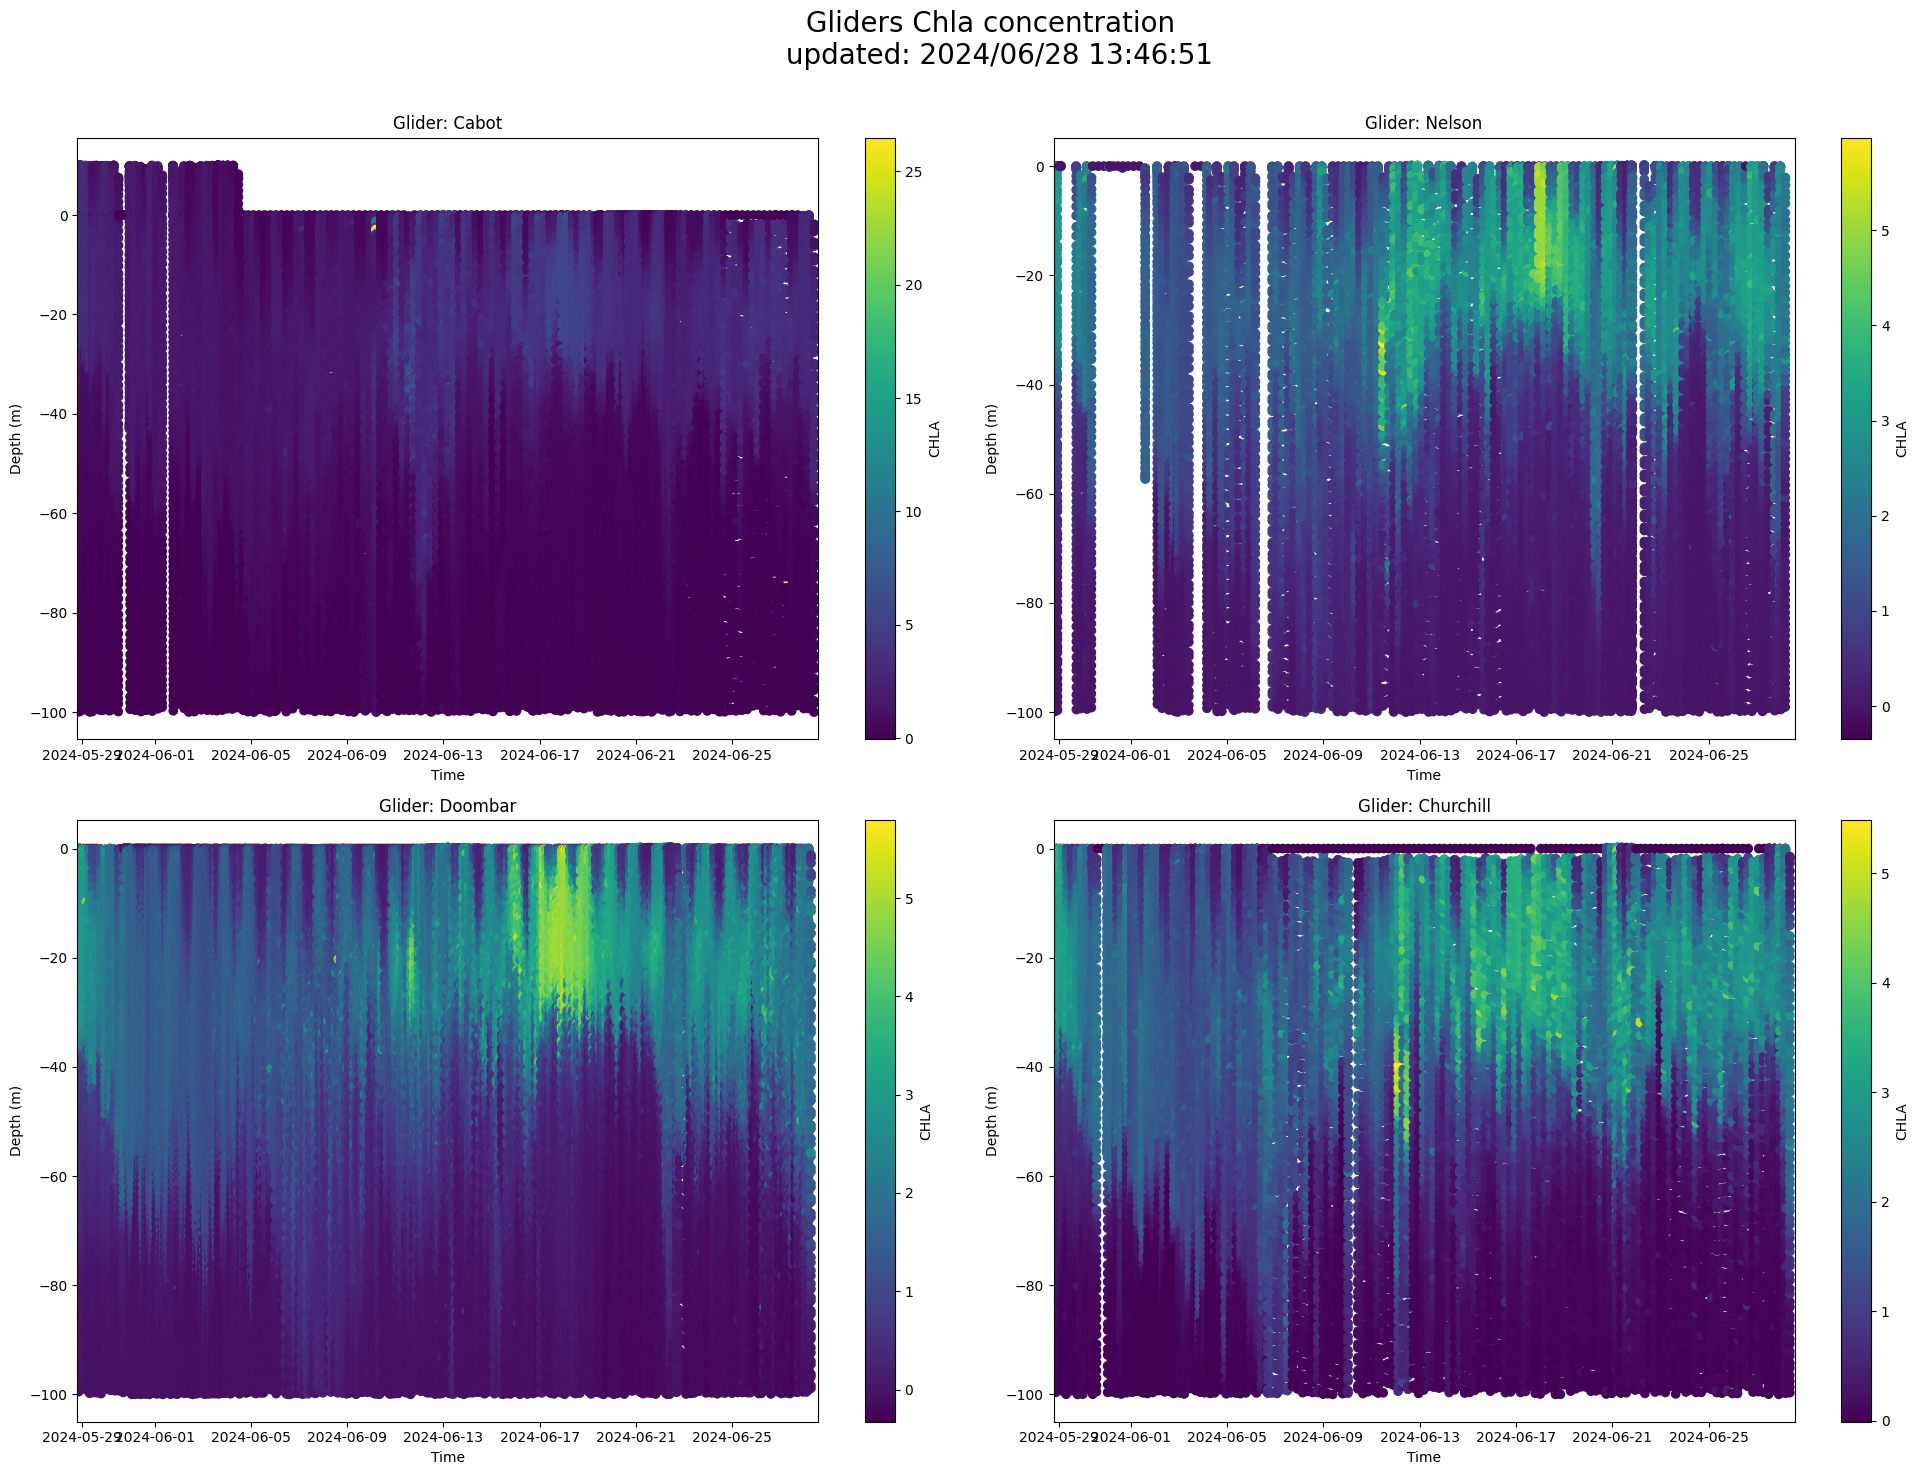

In [11]:
# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(20, 15))

# Flatten the array of axes for easy iteration
axs = axs.flatten()

# Loop through glider names and axes
for ax, glider_name in zip(axs, url_links.keys()):
    plot_bgc_var(ax, glider_name, var='CHLA', surface=True)


fig.suptitle(f'Gliders Chla concentration \n updated: {today}', size = 20)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

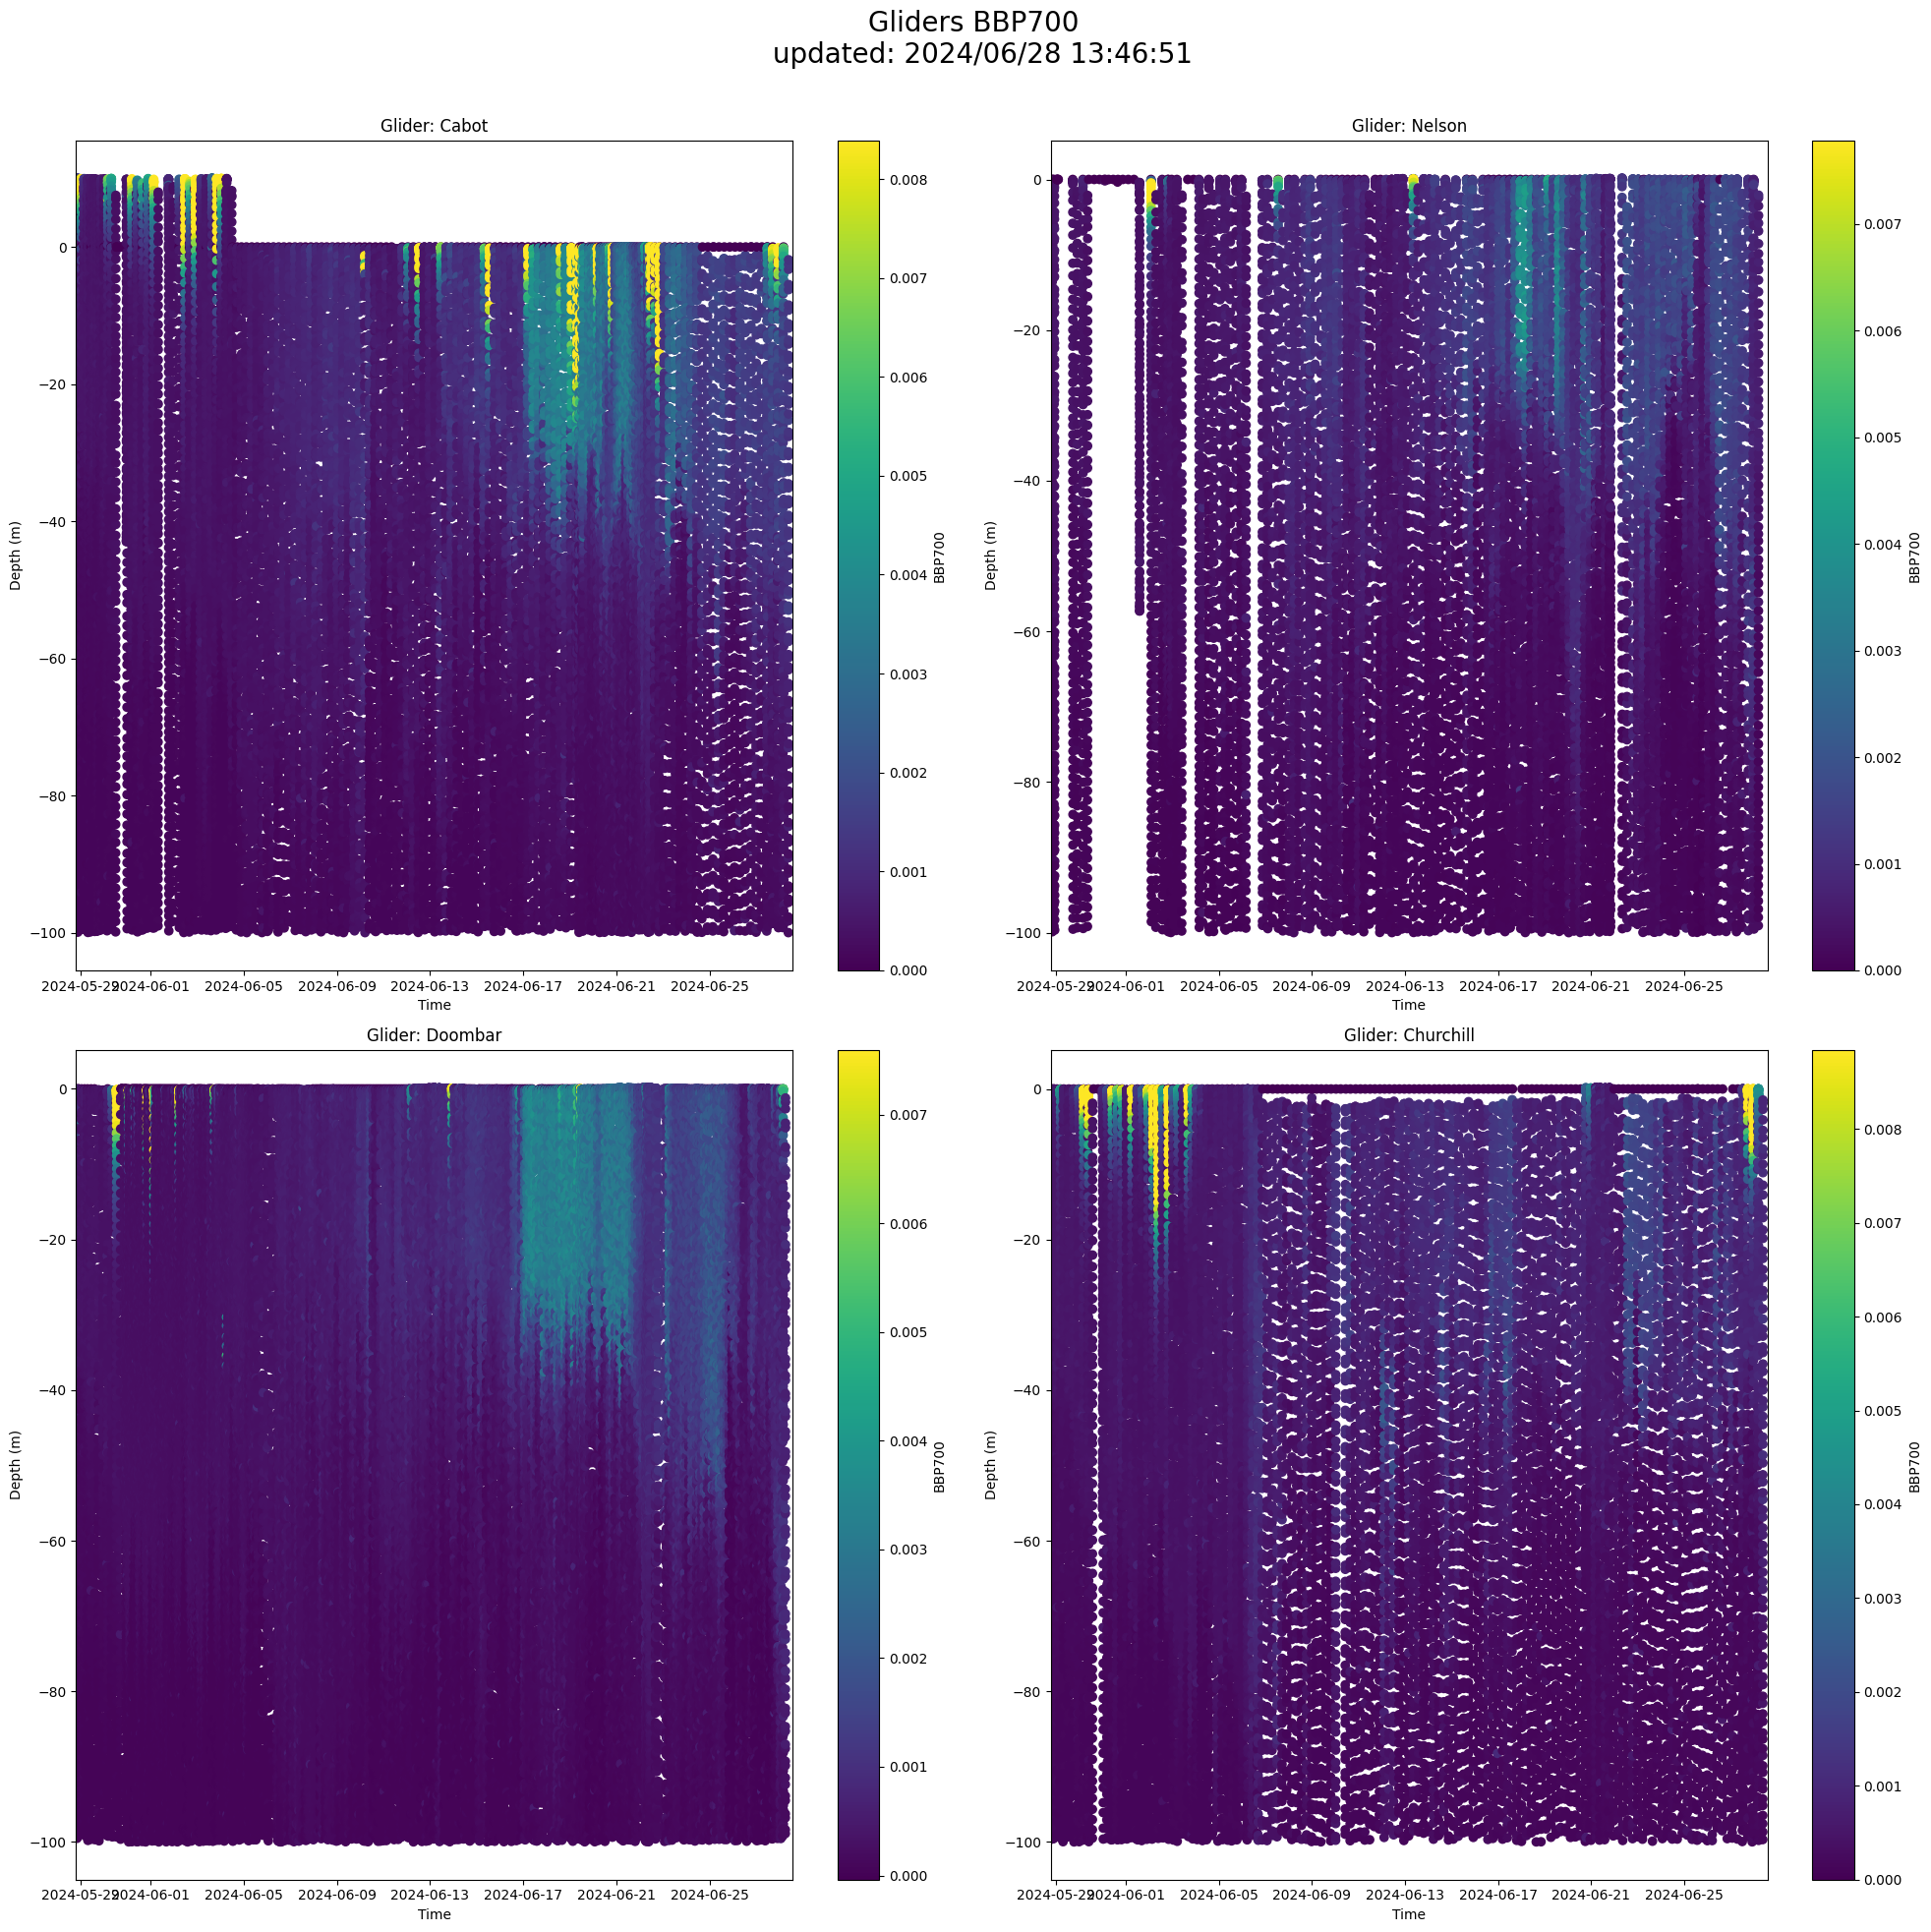

In [12]:
# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(20, 20))

# Flatten the array of axes for easy iteration
axs = axs.flatten()

# Loop through glider names and axes
for ax, glider_name in zip(axs, url_links.keys()):
    plot_bgc_var(ax, glider_name, var='BBP700', surface=True)


fig.suptitle(f'Gliders BBP700 \n updated: {today}', size = 20)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

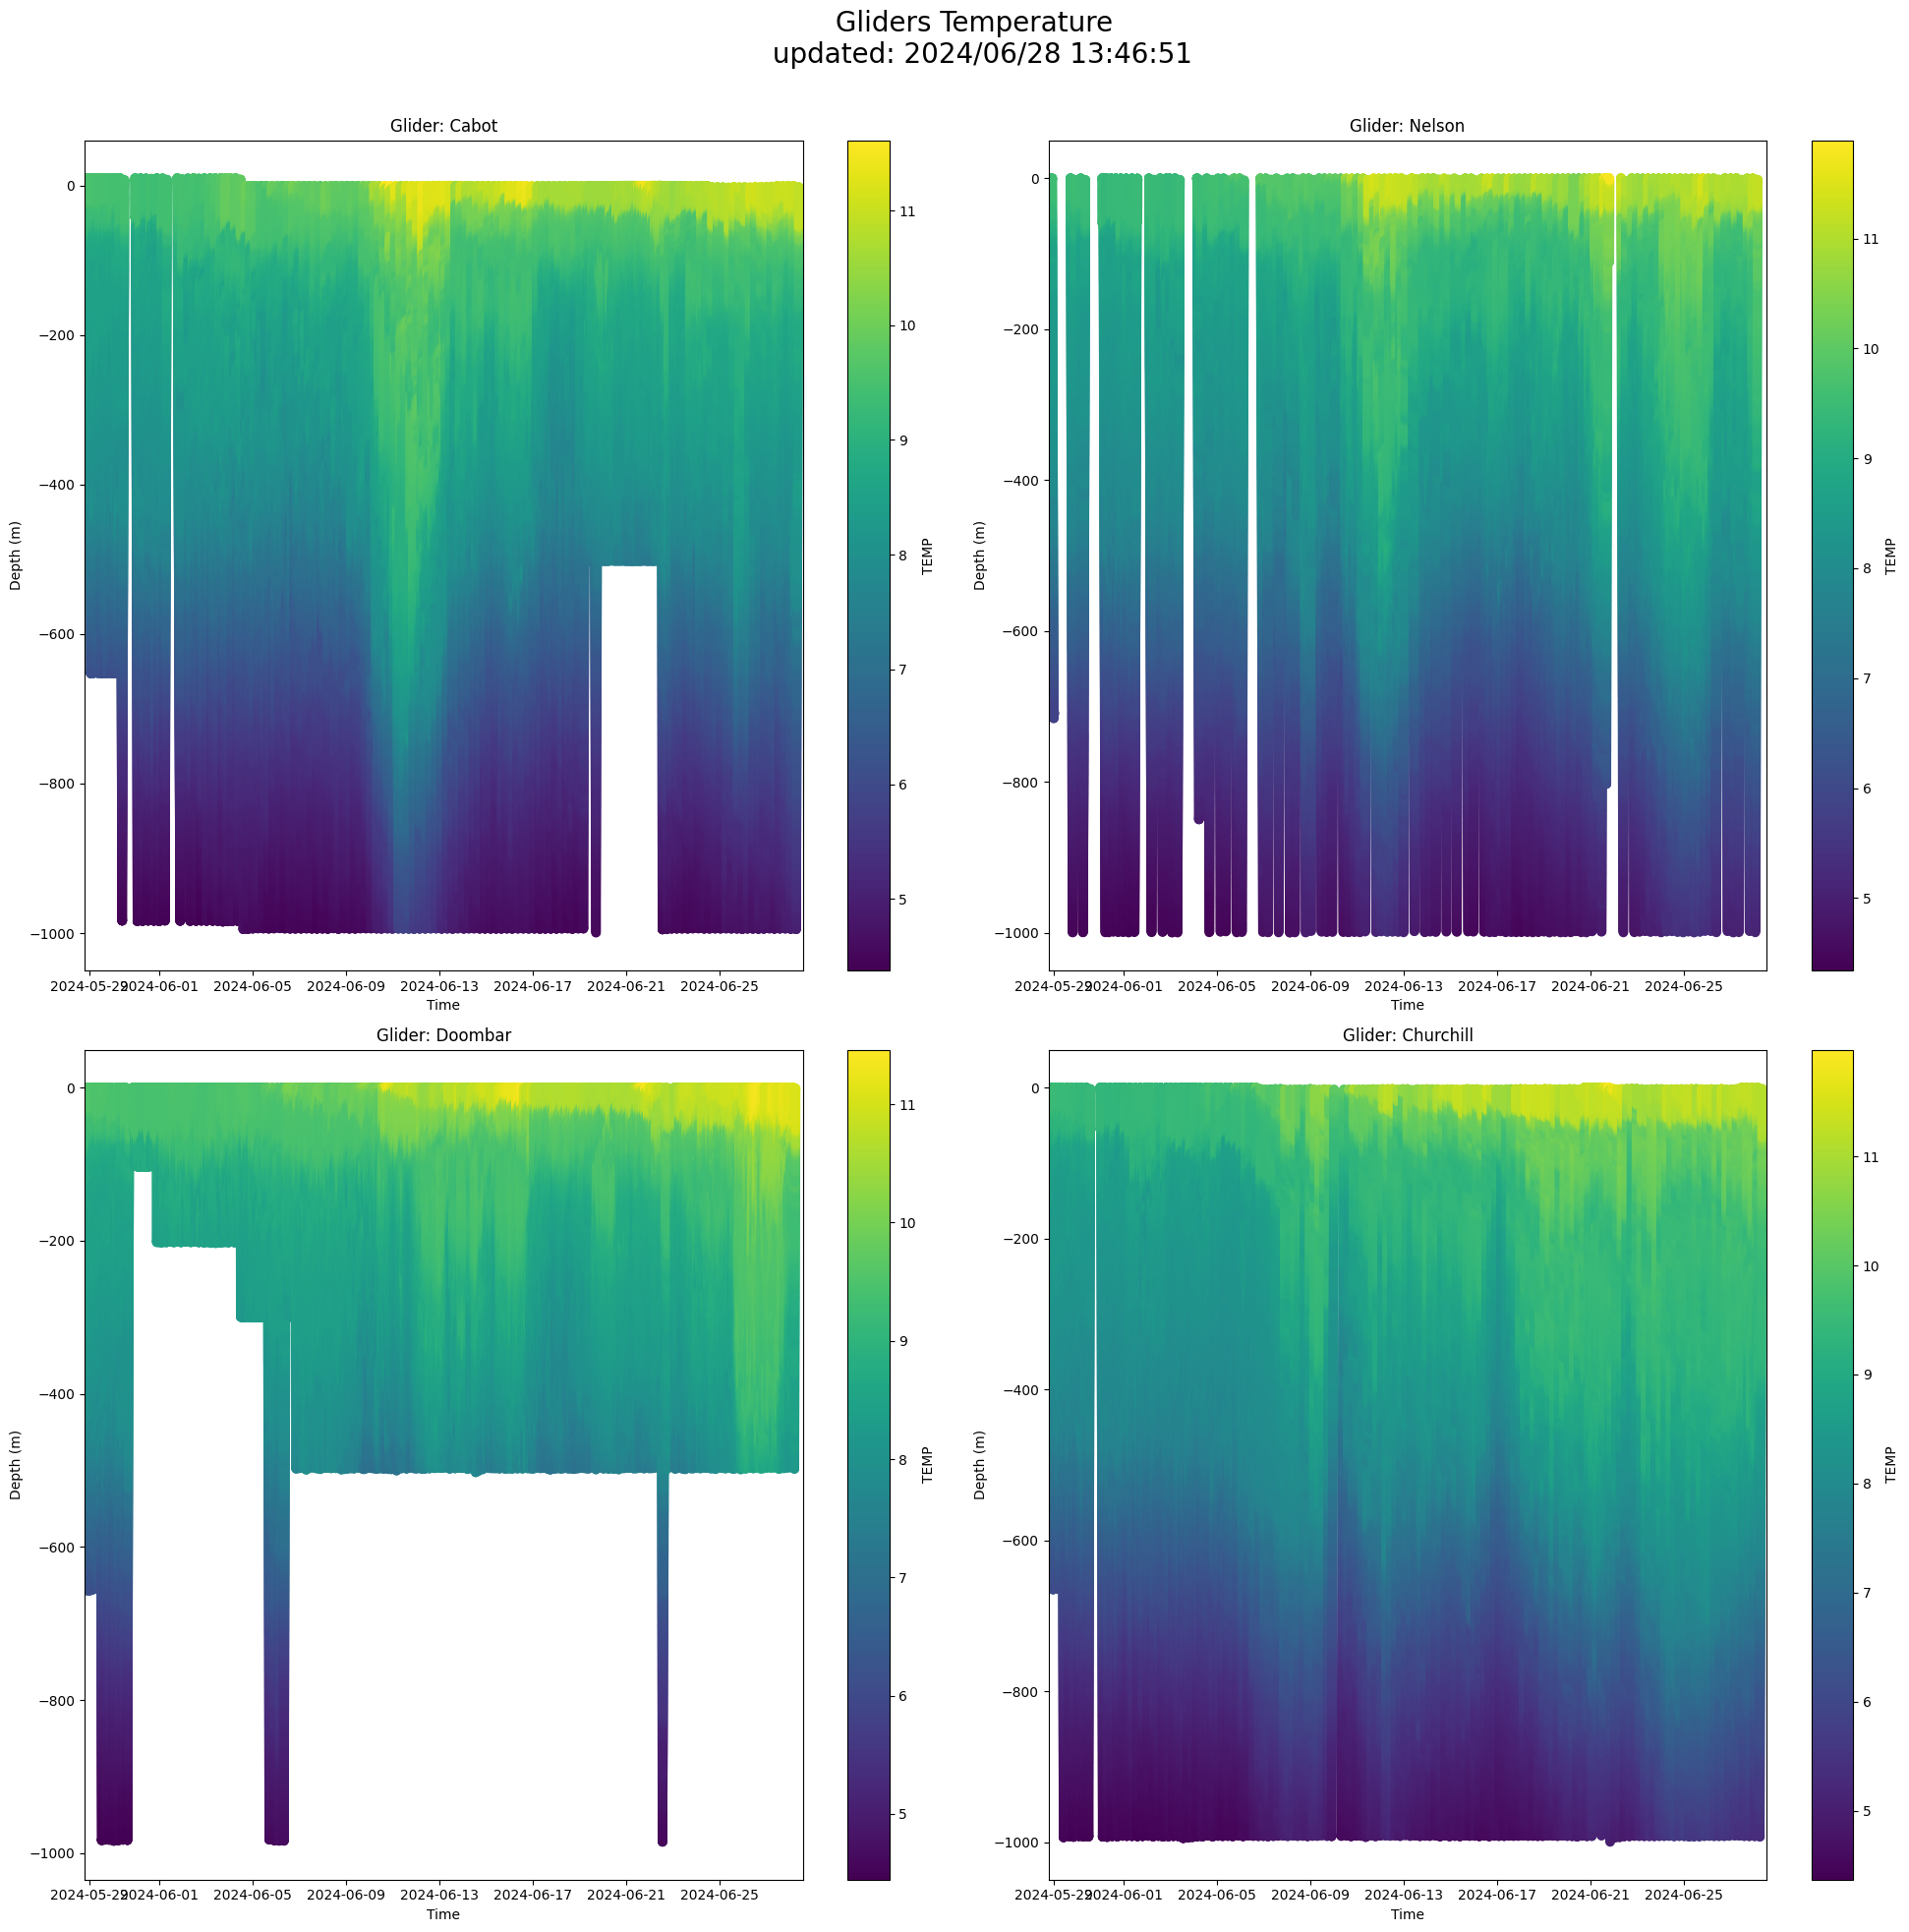

In [13]:
# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(20, 20))

# Flatten the array of axes for easy iteration
axs = axs.flatten()

# Loop through glider names and axes
for ax, glider_name in zip(axs, url_links.keys()):
    plot_bgc_var(ax, glider_name, var='TEMP', surface=False)


fig.suptitle(f'Gliders Temperature \n updated: {today}', size = 20)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

In [14]:
df = gliders_df[gliders_df['PRES'] < 10000]
df['LONGITUDE'] = df['LONGITUDE'].interpolate()
df['LATITUDE'] = df['LATITUDE'].interpolate()
df = df[['TIME', 'LONGITUDE', 'LATITUDE', 'PRES', 'CHLA', 'BBP700', 'glider']].dropna()

# Convert datetime to numerical values for interpolation
df['datetime_num'] = df['TIME'].astype('int64') / 1e9  # Convert to seconds since epoch

# Create the grid
grid_x, grid_y = np.meshgrid(
    np.linspace(df['datetime_num'].min(), df['datetime_num'].max(), 100),
    np.linspace(df['PRES'].min(), df['PRES'].max(), 100)
)


C:\Users\flapet\AppData\Local\Temp\ipykernel_14996\4158170034.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['LONGITUDE'] = df['LONGITUDE'].interpolate()
C:\Users\flapet\AppData\Local\Temp\ipykernel_14996\4158170034.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['LATITUDE'] = df['LATITUDE'].interpolate()


In [15]:
df.head()

TIME  LONGITUDE   LATITUDE      PRES  \
N_MEASUREMENTS                                                                 
4              2024-05-28 19:08:46.859832576 -23.981524  59.972603 -6.533333   
8              2024-05-28 19:08:56.990539776 -23.981133  59.972198 -9.750000   
11             2024-05-28 19:09:07.109893888 -23.981123  59.972195 -9.796667   
14             2024-05-28 19:09:17.252654592 -23.981115  59.972191 -9.997499   
19             2024-05-28 19:09:27.392333824 -23.981102  59.972187 -9.945000   

                  CHLA    BBP700 glider  datetime_num  
N_MEASUREMENTS                                         
4               2.2265  0.008391  Cabot  1.716923e+09  
8               2.1681  0.008391  Cabot  1.716923e+09  
11              2.3214  0.008391  Cabot  1.716923e+09  
14              2.4528  0.008391  Cabot  1.716923e+09  
19              2.2922  0.008391  Cabot  1.716923e+09

In [16]:
# Create an empty list to store profile values
diff_index = []
dfiff_time = 1
# Initialize the previous pressure value
prev_pres = 0
prev_time = None

speed_index = []

# Iterate over rows in the DataFrame
for index, row in df.iterrows():
    pres = row['PRES']
    time = row['TIME']
    #Compute the difference of pressure
    diff = pres - prev_pres
    diff_index.append(diff)

    if prev_time is None:
        speed = diff
    else:
        diff_time = time - prev_time
        diff_time = diff_time.total_seconds()
        speed = diff/diff_time

    speed_index.append(speed)
    # Update the previous pressure value
    prev_pres = pres
    prev_time = time



# Add the diff values to the DataFrame
df['diff'] = diff_index
df['speed'] = speed_index

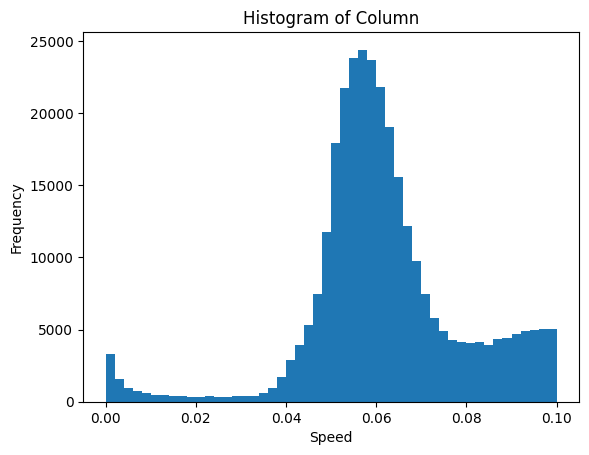

In [17]:
df['abs_diff'] = abs(df['diff'])
df['abs_speed'] = abs(df['speed'])
df_temp = df[df['abs_speed'] < 0.1]
plt.hist(df_temp['abs_speed'], bins=50)  # Adjust the number of bins as needed
plt.xlabel('Speed')
plt.ylabel('Frequency')
plt.title('Histogram of Column')
plt.show()

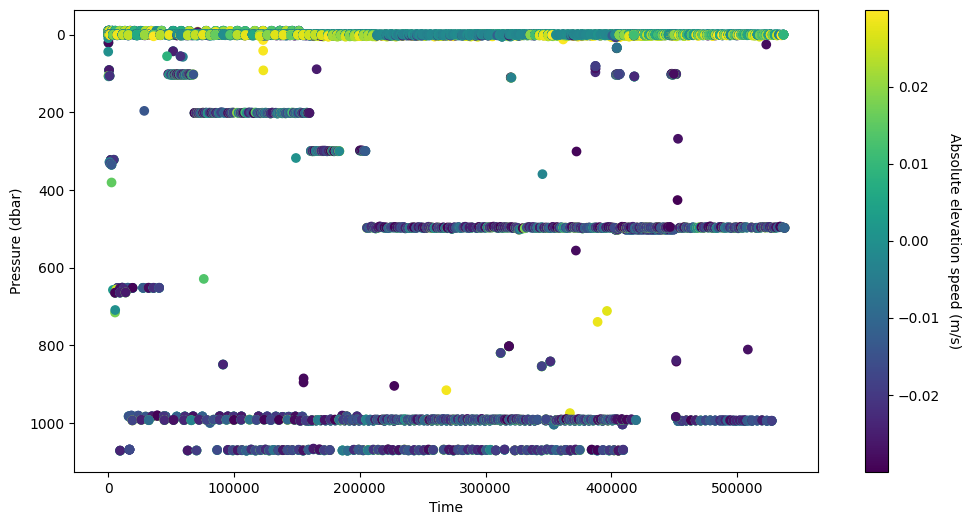

In [18]:
df1 = df[df['abs_speed'] < 0.03]


plt.figure(figsize=(12,6))
plt.scatter(x = df1.index, y = df1['PRES'], c = df1['speed'], cmap = 'viridis')
plt.gca().invert_yaxis()
plt.ylabel('Pressure (dbar)')
plt.xlabel('Time')
cbar = plt.colorbar(label='profile')
cbar.set_label('Absolute elevation speed (m/s)', rotation=270, labelpad=15)

In [19]:
# Create an initial profile value
profile = 1

# Create an empty list to store profile values
profile_values = []
ways = []
way_codes = []
# Initialize the previous pressure value
prev_way = None

# Iterate over rows in the DataFrame
for index, row in df.iterrows():
    pres = row['PRES']
    speed = row['speed']
    if abs(speed) <= 0.03:
        way = 'stationary'
        way_code = 0
    elif speed < 0:
        way = 'asc'
        way_code = 1
    else:
        way = 'desc'
        way_code = -1
    if way == 'stationary':
        profile_values.append(np.nan)
        way = prev_way
    elif prev_way is None or way == prev_way:
        profile_values.append(profile)
    else:
        profile += 1
        profile_values.append(profile)
    # Update the previous way value
    ways.append(way)
    prev_way = way
    way_codes.append(way_code)

# Add the profile values to the DataFrame
df['profile'] = profile_values
df['way'] = ways
df['way_code'] = way_codes

In [20]:
df = df.set_index('profile')

In [21]:
df['profile_codes'] = df['way_code'].rolling(window=3).median()

In [22]:
profile = 1
profile_values = []
prev_code = None
for index, row in df.iterrows():
    code = row['profile_codes']
    if prev_code is None or code == 0:
        profile_values.append(0)
    elif prev_code == code:
        profile_values.append(profile)
    else:
        profile += 1
        profile_values.append(profile)
    prev_code = code
df['new_profiles'] = profile_values 
    

In [23]:
df_clean = df[df['way_code'] != 0]

In [24]:
df_clean['new_profiles'].max()

1667

In [25]:
df_clean.head()

TIME  LONGITUDE   LATITUDE      PRES    CHLA  \
profile                                                                         
1.0     2024-05-28 19:08:46.859832576 -23.981524  59.972603 -6.533333  2.2265   
1.0     2024-05-28 19:08:56.990539776 -23.981133  59.972198 -9.750000  2.1681   
2.0     2024-05-28 19:10:48.230988288 -23.981186  59.971996 -9.392500  2.5696   
2.0     2024-05-28 19:10:58.305389056 -23.981211  59.971954 -8.882500  2.5112   
2.0     2024-05-28 19:11:08.350494208 -23.981226  59.971931 -8.219999  2.7229   

           BBP700 glider  datetime_num      diff     speed  abs_diff  \
profile                                                                
1.0      0.008391  Cabot  1.716923e+09 -6.533333 -6.533333  6.533333   
1.0      0.008391  Cabot  1.716923e+09 -3.216667 -0.317517  3.216667   
2.0      0.007973  Cabot  1.716923e+09  0.397500  0.039083  0.397500   
2.0      0.007199  Cabot  1.716923e+09  0.510000  0.050623  0.510000   
2.0      0.006280  Cabot  1.716923e+09  0.662500  0.065953  0.662500   

         abs_speed   way  way_code  profile_codes  new_profiles  
profile                                                          
1.0       6.533333   asc         1            NaN             0  
1.0       0.317517   asc         1            NaN             2  
2.0       0.039083  desc        -1            0.0             0  
2.0       0.050623  desc        -1           -1.0             4  
2.0       0.065953  desc        -1           -1.0             4

In [26]:
check = df_clean['new_profiles'].value_counts().sort_values()
one_profile = check[check.values == 1]

In [27]:
one_profile.keys()

Index([ 294, 1592,  278, 1578,  389, 1580,  387, 1582, 1593,  281,
       ...
        958,  953, 1217,  647, 1338, 1336, 1332, 1331, 1326,  946],
      dtype='int64', name='new_profiles', length=272)

In [28]:
df_clean = df_clean[~ df_clean['new_profiles'].isin(one_profile.keys())]

In [29]:
df_clean['new_profiles'].unique().shape

(1394,)

In [30]:
df_clean['profile_codes']

profile
1.0       NaN
2.0       0.0
2.0      -1.0
2.0      -1.0
2.0      -1.0
         ... 
1493.0    1.0
1493.0    1.0
1493.0    1.0
1493.0    1.0
1493.0    1.0
Name: profile_codes, Length: 716403, dtype: float64

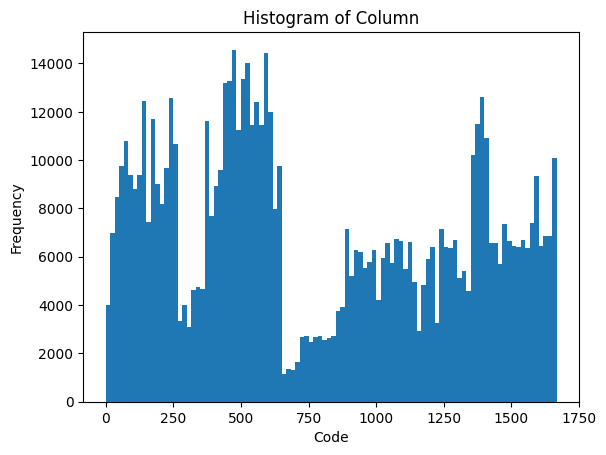

In [31]:
plt.hist(df_clean['new_profiles'], bins=100)  # Adjust the number of bins as needed
plt.xlabel('Code')
plt.ylabel('Frequency')
plt.title('Histogram of Column')
plt.show()

In [33]:
df_clean.to_csv(parent_dir + '/Output/gliders_ecopuk')

In [ ]:
df_clean.head()

In [ ]:
temp_df= df_clean[df_clean['new_profiles'] == 0] 
figname = parent_dir + '/Output/Plots/profiles/prof_' + str(i) + '.png'
max_depth = temp_df['PRES'].max()
fig, ax = plt.subplots(1, 3, figsize=(10, 10))

# First subplot
ax[0].scatter(x=temp_df['CHLA'], y=temp_df['PRES'])
ax[0].invert_yaxis()
ax[0].set_ylabel('Pressure (dbar)')
ax[0].set_xlabel('Chlorophyll-a')

# Second subplot
ax[1].scatter(x=temp_df['CHLA'], y=temp_df['PRES'])
ax[1].invert_yaxis()
ax[1].set_ylim([10,0])
ax[1].set_ylabel('Pressure (dbar)')
ax[1].set_xlabel('Chlorophyll-a')

# Third subplot
ax[2].scatter(x=temp_df['CHLA'], y=temp_df['PRES'])
ax[2].invert_yaxis()
ax[2].set_ylim([max_depth + 1, max_depth - 10])
ax[2].set_ylabel('Pressure (dbar)')
ax[2].set_xlabel('Chlorophyll-a')

plt.show()


In [ ]:
from matplotlib import colormaps
cmap = colormaps['Set1']

plt.figure(figsize=(12,6))
plt.scatter(x = df['TIME'], y = df['PRES'], c = df.index, cmap = 'viridis')
plt.gca().invert_yaxis()
plt.ylabel('Pressure (dbar)')
plt.xlabel('Time')
cbar = plt.colorbar(label='profile')
cbar.set_label('Porifle number', rotation=270, labelpad=15)

In [ ]:
parent_dir